In [1]:
import os
import glob
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.backends import cudnn

import torchvision.transforms.functional as T
from torchvision.transforms import ToTensor, ToPILImage, RandomCrop


In [2]:
class MDTA(nn.Module):
    def __init__(self, channels, num_heads):
        super(MDTA, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(1, num_heads, 1, 1))

        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.qkv_conv = nn.Conv2d(channels * 3, channels * 3, kernel_size=3, padding=1, groups=channels * 3, bias=False)
        self.project_out = nn.Conv2d(channels, channels, kernel_size=1, bias=False)

    def forward(self, x):
        b, c, h, w = x.shape
        q, k, v = self.qkv_conv(self.qkv(x)).chunk(3, dim=1)

        q = q.reshape(b, self.num_heads, -1, h * w)
        k = k.reshape(b, self.num_heads, -1, h * w)
        v = v.reshape(b, self.num_heads, -1, h * w)
        q, k = F.normalize(q, dim=-1), F.normalize(k, dim=-1)

        attn = torch.softmax(torch.matmul(q, k.transpose(-2, -1).contiguous()) * self.temperature, dim=-1)
        out = self.project_out(torch.matmul(attn, v).reshape(b, -1, h, w))
        return out

class GDFN(nn.Module):
    def __init__(self, channels, expansion_factor):
        super(GDFN, self).__init__()

        hidden_channels = int(channels * expansion_factor)
        self.project_in = nn.Conv2d(channels, hidden_channels * 2, kernel_size=1, bias=False)
        self.conv = nn.Conv2d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1,
                              groups=hidden_channels * 2, bias=False)
        self.project_out = nn.Conv2d(hidden_channels, channels, kernel_size=1, bias=False)

    def forward(self, x):
        x1, x2 = self.conv(self.project_in(x)).chunk(2, dim=1)
        x = self.project_out(F.gelu(x1) * x2)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, channels, num_heads, expansion_factor):
        super(TransformerBlock, self).__init__()

        self.norm1 = nn.LayerNorm(channels)
        self.attn = MDTA(channels, num_heads)
        self.norm2 = nn.LayerNorm(channels)
        self.ffn = GDFN(channels, expansion_factor)

    def forward(self, x):
        b, c, h, w = x.shape
        x = x + self.attn(self.norm1(x.reshape(b, c, -1).transpose(-2, -1).contiguous()).transpose(-2, -1)
                          .contiguous().reshape(b, c, h, w))
        x = x + self.ffn(self.norm2(x.reshape(b, c, -1).transpose(-2, -1).contiguous()).transpose(-2, -1)
                         .contiguous().reshape(b, c, h, w))
        return x

class DownSample(nn.Module):
    def __init__(self, channels):
        super(DownSample, self).__init__()
        self.body = nn.Sequential(nn.Conv2d(channels, channels // 2, kernel_size=3, padding=1, bias=False),
                                  nn.PixelUnshuffle(2))

    def forward(self, x):
        return self.body(x)

class UpSample(nn.Module):
    def __init__(self, channels):
        super(UpSample, self).__init__()
        self.body = nn.Sequential(nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
                                  nn.PixelShuffle(2))

    def forward(self, x):
        return self.body(x)

class Restormer(nn.Module):
    def __init__(self, num_blocks=[4, 6, 6, 8], num_heads=[1, 2, 4, 8], channels=[48, 96, 192, 384], num_refinement=4,
                 expansion_factor=2.66):
        super(Restormer, self).__init__()

        self.embed_conv = nn.Conv2d(3, channels[0], kernel_size=3, padding=1, bias=False)

        self.encoders = nn.ModuleList([nn.Sequential(*[TransformerBlock(
            num_ch, num_ah, expansion_factor) for _ in range(num_tb)]) for num_tb, num_ah, num_ch in
                                       zip(num_blocks, num_heads, channels)])
        # the number of down sample or up sample == the number of encoder - 1
        self.downs = nn.ModuleList([DownSample(num_ch) for num_ch in channels[:-1]])
        self.ups = nn.ModuleList([UpSample(num_ch) for num_ch in list(reversed(channels))[:-1]])
        # the number of reduce block == the number of decoder - 1
        self.reduces = nn.ModuleList([nn.Conv2d(channels[i], channels[i - 1], kernel_size=1, bias=False)
                                      for i in reversed(range(2, len(channels)))])
        # the number of decoder == the number of encoder - 1
        self.decoders = nn.ModuleList([nn.Sequential(*[TransformerBlock(channels[2], num_heads[2], expansion_factor)
                                                       for _ in range(num_blocks[2])])])
        self.decoders.append(nn.Sequential(*[TransformerBlock(channels[1], num_heads[1], expansion_factor)
                                             for _ in range(num_blocks[1])]))
        # the channel of last one is not change
        self.decoders.append(nn.Sequential(*[TransformerBlock(channels[1], num_heads[0], expansion_factor)
                                             for _ in range(num_blocks[0])]))

        self.refinement = nn.Sequential(*[TransformerBlock(channels[1], num_heads[0], expansion_factor)
                                          for _ in range(num_refinement)])
        self.output = nn.Conv2d(channels[1], 3, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        fo = self.embed_conv(x)
        out_enc1 = self.encoders[0](fo)
        out_enc2 = self.encoders[1](self.downs[0](out_enc1))
        out_enc3 = self.encoders[2](self.downs[1](out_enc2))
        out_enc4 = self.encoders[3](self.downs[2](out_enc3))

        out_dec3 = self.decoders[0](self.reduces[0](torch.cat([self.ups[0](out_enc4), out_enc3], dim=1)))
        out_dec2 = self.decoders[1](self.reduces[1](torch.cat([self.ups[1](out_dec3), out_enc2], dim=1)))
        fd = self.decoders[2](torch.cat([self.ups[2](out_dec2), out_enc1], dim=1))
        fr = self.refinement(fd)
        out = self.output(fr) + x
        return out


In [3]:
# ============================
# Dataset class
# ============================
class RainDataset(Dataset):
    def __init__(self, input_dir, target_dir, patch_size=None, length=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.image_names = os.listdir(self.input_dir)
        self.patch_size = patch_size
        self.length = length or len(self.image_names)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        index %= len(self.image_names)
        input_path = os.path.join(self.input_dir, self.image_names[index])
        target_path = os.path.join(self.target_dir, self.image_names[index])
    
        input_image = Image.open(input_path).convert('RGB')
        target_image = Image.open(target_path).convert('RGB')
    
        input_tensor = torch.from_numpy(np.array(input_image)).permute(2, 0, 1).float() / 255.0
        target_tensor = torch.from_numpy(np.array(target_image)).permute(2, 0, 1).float() / 255.0
    
        h, w = input_tensor.shape[1], input_tensor.shape[2]
        if self.patch_size:
            ph, pw = self.patch_size, self.patch_size
            th = torch.randint(0, h - ph + 1, (1,)).item()
            tw = torch.randint(0, w - pw + 1, (1,)).item()
            input_tensor = input_tensor[:, th:th + ph, tw:tw + pw]
            target_tensor = target_tensor[:, th:th + ph, tw:tw + pw]
    
        return input_tensor, target_tensor, self.image_names[index], h, w

# ============================
# Helper functions
# ============================
def rgb_to_y(x):
    rgb_to_grey = torch.tensor([0.256789, 0.504129, 0.097906], dtype=x.dtype, device=x.device).view(1, -1, 1, 1)
    return torch.sum(x * rgb_to_grey, dim=1, keepdim=True).add(16.0)

def psnr(x, y, data_range=1.0):
    mse = torch.mean((x - y) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(data_range / torch.sqrt(mse))


def ssim(x, y, kernel_size=11, kernel_sigma=1.5, data_range=1.0, k1=0.01, k2=0.03):
    coords = torch.arange(kernel_size, dtype=x.dtype, device=x.device)
    coords -= (kernel_size - 1) / 2.0
    g = coords ** 2
    g = (- (g.unsqueeze(0) + g.unsqueeze(1)) / (2 * kernel_sigma ** 2)).exp()
    g /= g.sum()
    kernel = g.unsqueeze(0).repeat(x.size(1), 1, 1, 1)

    c1, c2 = (k1 * data_range) ** 2, (k2 * data_range) ** 2
    n_channels = x.size(1)
    mu_x = F.conv2d(x, weight=kernel, stride=1, padding=0, groups=n_channels)
    mu_y = F.conv2d(y, weight=kernel, stride=1, padding=0, groups=n_channels)

    mu_xx, mu_yy, mu_xy = mu_x ** 2, mu_y ** 2, mu_x * mu_y
    sigma_xx = F.conv2d(x ** 2, weight=kernel, stride=1, padding=0, groups=n_channels) - mu_xx
    sigma_yy = F.conv2d(y ** 2, weight=kernel, stride=1, padding=0, groups=n_channels) - mu_yy
    sigma_xy = F.conv2d(x * y, weight=kernel, stride=1, padding=0, groups=n_channels) - mu_xy

    cs = (2.0 * sigma_xy + c2) / (sigma_xx + sigma_yy + c2)
    ss = (2.0 * mu_xy + c1) / (mu_xx + mu_yy + c1) * cs
    return ss.mean()

# ============================
# Training and Evaluation Loops
# ============================
def test_loop(net, data_loader, num_iter, args):
    net.eval()
    total_psnr, total_ssim, total_loss, count = 0.0, 0.0, 0.0, 0
    loss_fn = nn.L1Loss()
    with torch.no_grad():
        for rain, norain, _, _, _ in tqdm(data_loader, desc=f"Validation {num_iter}/{args.num_iter}", dynamic_ncols=True):
            rain, norain = rain.cuda(), norain.cuda()
            out = torch.clamp(net(rain), 0, 1)
            
            loss = loss_fn(out, norain)
            total_loss += loss.item()
            
            total_psnr += psnr(out, norain)
            total_ssim += ssim(out, norain)
            count += 1
    
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    avg_loss = total_loss / count

    print(f"[Validation] Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim, avg_loss

def process_and_test_random_image(model, folder_input, folder_target):

    input_files = os.listdir(folder_input)
    random_file = random.choice(input_files) 


    input_path = os.path.join(folder_input, random_file)
    target_path = os.path.join(folder_target, random_file)

    input_image = Image.open(input_path).convert('RGB')
    target_image = Image.open(target_path).convert('RGB')


    input_tensor = ToTensor()(input_image).unsqueeze(0).cuda()
    target_tensor = ToTensor()(target_image)

  
    model.eval()
    with torch.no_grad():
        denoised_tensor = torch.clamp(model(input_tensor), 0, 1).squeeze(0).cpu()

    input_y = rgb_to_y(input_tensor.cpu())
    target_y = rgb_to_y(target_tensor.unsqueeze(0))
    denoised_y = rgb_to_y(denoised_tensor.unsqueeze(0))

    psnr_test = psnr(denoised_y, target_y)
    ssim_test = ssim(denoised_y, target_y)

    print(f"Random Test Image: {random_file}, PSNR: {psnr_test:.2f}, SSIM: {ssim_test:.4f}")

    to_pil = ToPILImage()
    input_image_np = to_pil(input_tensor.squeeze(0).cpu())
    target_image_np = to_pil(target_tensor)
    denoised_image_np = to_pil(denoised_tensor)


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image_np)
    axes[0].set_title("Input Image")
    axes[1].imshow(target_image_np)
    axes[1].set_title("Target Image")
    axes[2].imshow(denoised_image_np)
    axes[2].set_title("Denoised Image")
    plt.show()


def process_and_test_all_images(model, folder_input, folder_target):
    input_files = os.listdir(folder_input)

    total_psnr = 0
    total_ssim = 0
    num_images = 0

    model.eval()
    
    for random_file in tqdm(input_files, desc="Processing Images"):
        input_path = os.path.join(folder_input, random_file)
        target_path = os.path.join(folder_target, random_file)

        if not os.path.exists(target_path):
            print(f"Target file missing for: {random_file}")
            continue

        input_image = Image.open(input_path).convert('RGB')
        target_image = Image.open(target_path).convert('RGB')

        input_tensor = ToTensor()(input_image).unsqueeze(0).cuda()
        target_tensor = ToTensor()(target_image)

        with torch.no_grad():
            denoised_tensor = torch.clamp(model(input_tensor), 0, 1).squeeze(0).cpu()

        input_y = rgb_to_y(input_tensor.cpu())
        target_y = rgb_to_y(target_tensor.unsqueeze(0))
        denoised_y = rgb_to_y(denoised_tensor.unsqueeze(0))

        psnr_test = psnr(denoised_y, target_y)
        ssim_test = ssim(denoised_y, target_y)

        total_psnr += psnr_test
        total_ssim += ssim_test
        num_images += 1

    if num_images > 0:
        avg_psnr = total_psnr / num_images
        avg_ssim = total_ssim / num_images

        print(f"\nAverage PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")

# ============================
# Main Entry
# ============================
if __name__ == '__main__':
    class Args:
        def __init__(self):
            self.data_path = '/kaggle/input/rain13kdataset/train/train/'
            self.save_path = 'results'
            self.num_blocks = [2, 3, 3, 4]
            self.num_heads = [1, 2, 4, 8]
            self.channels = [48, 96, 192, 384]
            self.expansion_factor = 2.66
            self.num_refinement = 4
            self.num_iter = 50
            self.lr = 1e-4
            self.batch_size = 4
            self.workers = 4
            self.model_file = None

    args = Args()
    dataset = RainDataset(
        input_dir='/kaggle/input/rain13kdataset/train/train/Rain13K/input',
        target_dir='/kaggle/input/rain13kdataset/train/train/Rain13K/target',
        patch_size=64
    )

    total_length = len(dataset)
    val_length = int(total_length * 0.2)
    train_length = total_length - val_length

    train_dataset, val_dataset = random_split(dataset, [train_length, val_length])

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=args.workers)

    model = Restormer(args.num_blocks, args.num_heads, args.channels, args.num_refinement, args.expansion_factor).cuda()
    optimizer = AdamW(model.parameters(), lr=args.lr, betas=(0.9, 0.999))
    scheduler = CosineAnnealingLR(optimizer, T_max=args.num_iter)

    log_file = "gridsearch_log.txt"

    with open(log_file, "w") as f:
        f.write("Batch Size, Epoch, Training Loss, Avg PSNR, Avg SSIM\n")

train_losses = []
val_losses = []
psnr_vals = []
ssim_vals = []
for epoch in range(1, args.num_iter + 1):
    model.train()
    running_loss = 0.0
    for rain, norain, _, _, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{args.num_iter}", dynamic_ncols=True):
        rain, norain = rain.cuda(), norain.cuda()
        optimizer.zero_grad()
        output = model(rain)
        loss = F.l1_loss(output, norain)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    psnr_val, ssim_val, val_loss = test_loop(model, val_loader, epoch, args)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    psnr_vals.append(psnr_val.item() if isinstance(psnr_val, torch.Tensor) else psnr_val)
    ssim_vals.append(ssim_val.item() if isinstance(ssim_val, torch.Tensor) else ssim_val)

    with open(log_file, "a") as f:
        f.write(f"{args.batch_size}, {epoch}, {avg_train_loss:.4f}, {val_loss:.4f}, {psnr_val:.4f}, {ssim_val:.4f}\n")

    print(f"[Epoch {epoch}] Training Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation PSNR: {psnr_val:.2f}, Validation SSIM: {ssim_val:.4f}")

    if epoch % 5 == 0 or epoch == 1:
        if not os.path.exists(args.save_path):
            os.makedirs(args.save_path)
        torch.save(model.state_dict(), f"{args.save_path}/model_bs{args.batch_size}_epoch{epoch}.pth")
        print(f"Model saved at {args.save_path}/model_bs{args.batch_size}_epoch{epoch}.pth")
    scheduler.step()

Validation 1/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.98it/s]


[Validation] Loss: 0.0391, PSNR: 27.60, SSIM: 0.8202
[Epoch 1] Training Loss: 0.0453, Validation Loss: 0.0391, Validation PSNR: 27.60, Validation SSIM: 0.8202
Model saved at results/model_bs4_epoch1.pth


Validation 2/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.32it/s]


[Validation] Loss: 0.0358, PSNR: 28.31, SSIM: 0.8343
[Epoch 2] Training Loss: 0.0355, Validation Loss: 0.0358, Validation PSNR: 28.31, Validation SSIM: 0.8343


Validation 3/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.27it/s]


[Validation] Loss: 0.0324, PSNR: 29.00, SSIM: 0.8569
[Epoch 3] Training Loss: 0.0324, Validation Loss: 0.0324, Validation PSNR: 29.00, Validation SSIM: 0.8569


Validation 4/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.25it/s]


[Validation] Loss: 0.0316, PSNR: 29.37, SSIM: 0.8579
[Epoch 4] Training Loss: 0.0314, Validation Loss: 0.0316, Validation PSNR: 29.37, Validation SSIM: 0.8579


Validation 5/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.63it/s]


[Validation] Loss: 0.0314, PSNR: 29.48, SSIM: 0.8638
[Epoch 5] Training Loss: 0.0302, Validation Loss: 0.0314, Validation PSNR: 29.48, Validation SSIM: 0.8638
Model saved at results/model_bs4_epoch5.pth


Validation 6/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.92it/s]


[Validation] Loss: 0.0294, PSNR: 29.87, SSIM: 0.8710
[Epoch 6] Training Loss: 0.0297, Validation Loss: 0.0294, Validation PSNR: 29.87, Validation SSIM: 0.8710


Validation 7/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.73it/s]


[Validation] Loss: 0.0291, PSNR: 29.80, SSIM: 0.8737
[Epoch 7] Training Loss: 0.0290, Validation Loss: 0.0291, Validation PSNR: 29.80, Validation SSIM: 0.8737


Validation 8/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.20it/s]


[Validation] Loss: 0.0285, PSNR: 30.03, SSIM: 0.8768
[Epoch 8] Training Loss: 0.0286, Validation Loss: 0.0285, Validation PSNR: 30.03, Validation SSIM: 0.8768


Validation 9/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.50it/s]


[Validation] Loss: 0.0278, PSNR: 30.34, SSIM: 0.8820
[Epoch 9] Training Loss: 0.0281, Validation Loss: 0.0278, Validation PSNR: 30.34, Validation SSIM: 0.8820


Validation 10/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.27it/s]


[Validation] Loss: 0.0273, PSNR: 30.41, SSIM: 0.8831
[Epoch 10] Training Loss: 0.0278, Validation Loss: 0.0273, Validation PSNR: 30.41, Validation SSIM: 0.8831
Model saved at results/model_bs4_epoch10.pth


Validation 11/50: 100%|██████████| 2742/2742 [01:14<00:00, 36.62it/s]


[Validation] Loss: 0.0281, PSNR: 30.13, SSIM: 0.8814
[Epoch 11] Training Loss: 0.0273, Validation Loss: 0.0281, Validation PSNR: 30.13, Validation SSIM: 0.8814


Validation 12/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.45it/s]


[Validation] Loss: 0.0283, PSNR: 30.18, SSIM: 0.8825
[Epoch 12] Training Loss: 0.0274, Validation Loss: 0.0283, Validation PSNR: 30.18, Validation SSIM: 0.8825


Validation 13/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.29it/s]


[Validation] Loss: 0.0266, PSNR: 30.56, SSIM: 0.8857
[Epoch 13] Training Loss: 0.0267, Validation Loss: 0.0266, Validation PSNR: 30.56, Validation SSIM: 0.8857


Validation 14/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.13it/s]


[Validation] Loss: 0.0273, PSNR: 30.49, SSIM: 0.8840
[Epoch 14] Training Loss: 0.0266, Validation Loss: 0.0273, Validation PSNR: 30.49, Validation SSIM: 0.8840


Validation 15/50: 100%|██████████| 2742/2742 [01:16<00:00, 36.01it/s]


[Validation] Loss: 0.0262, PSNR: 30.75, SSIM: 0.8893
[Epoch 15] Training Loss: 0.0264, Validation Loss: 0.0262, Validation PSNR: 30.75, Validation SSIM: 0.8893
Model saved at results/model_bs4_epoch15.pth


Validation 16/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.75it/s]


[Validation] Loss: 0.0253, PSNR: 30.95, SSIM: 0.8921
[Epoch 16] Training Loss: 0.0256, Validation Loss: 0.0253, Validation PSNR: 30.95, Validation SSIM: 0.8921


Validation 17/50: 100%|██████████| 2742/2742 [01:16<00:00, 36.04it/s]


[Validation] Loss: 0.0255, PSNR: 30.89, SSIM: 0.8930
[Epoch 17] Training Loss: 0.0257, Validation Loss: 0.0255, Validation PSNR: 30.89, Validation SSIM: 0.8930


Validation 18/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.82it/s]


[Validation] Loss: 0.0258, PSNR: 30.86, SSIM: 0.8908
[Epoch 18] Training Loss: 0.0254, Validation Loss: 0.0258, Validation PSNR: 30.86, Validation SSIM: 0.8908


Validation 19/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.85it/s]


[Validation] Loss: 0.0252, PSNR: 30.98, SSIM: 0.8940
[Epoch 19] Training Loss: 0.0252, Validation Loss: 0.0252, Validation PSNR: 30.98, Validation SSIM: 0.8940


Validation 20/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.71it/s]


[Validation] Loss: 0.0251, PSNR: 31.17, SSIM: 0.8957
[Epoch 20] Training Loss: 0.0249, Validation Loss: 0.0251, Validation PSNR: 31.17, Validation SSIM: 0.8957
Model saved at results/model_bs4_epoch20.pth


Validation 21/50: 100%|██████████| 2742/2742 [01:16<00:00, 36.05it/s]


[Validation] Loss: 0.0247, PSNR: 31.23, SSIM: 0.8978
[Epoch 21] Training Loss: 0.0248, Validation Loss: 0.0247, Validation PSNR: 31.23, Validation SSIM: 0.8978


Validation 22/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.92it/s]


[Validation] Loss: 0.0249, PSNR: 31.24, SSIM: 0.8965
[Epoch 22] Training Loss: 0.0244, Validation Loss: 0.0249, Validation PSNR: 31.24, Validation SSIM: 0.8965


Validation 23/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.54it/s]


[Validation] Loss: 0.0249, PSNR: 31.15, SSIM: 0.8957
[Epoch 23] Training Loss: 0.0244, Validation Loss: 0.0249, Validation PSNR: 31.15, Validation SSIM: 0.8957


Validation 24/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.10it/s]


[Validation] Loss: 0.0251, PSNR: 30.94, SSIM: 0.8952
[Epoch 24] Training Loss: 0.0242, Validation Loss: 0.0251, Validation PSNR: 30.94, Validation SSIM: 0.8952


Validation 25/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.09it/s]


[Validation] Loss: 0.0241, PSNR: 31.40, SSIM: 0.8977
[Epoch 25] Training Loss: 0.0243, Validation Loss: 0.0241, Validation PSNR: 31.40, Validation SSIM: 0.8977
Model saved at results/model_bs4_epoch25.pth


Validation 26/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.72it/s]


[Validation] Loss: 0.0243, PSNR: 31.41, SSIM: 0.9005
[Epoch 26] Training Loss: 0.0241, Validation Loss: 0.0243, Validation PSNR: 31.41, Validation SSIM: 0.9005


Validation 27/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.74it/s]


[Validation] Loss: 0.0243, PSNR: 31.29, SSIM: 0.8990
[Epoch 27] Training Loss: 0.0239, Validation Loss: 0.0243, Validation PSNR: 31.29, Validation SSIM: 0.8990


Validation 28/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.35it/s]


[Validation] Loss: 0.0242, PSNR: 31.42, SSIM: 0.9019
[Epoch 28] Training Loss: 0.0237, Validation Loss: 0.0242, Validation PSNR: 31.42, Validation SSIM: 0.9019


Validation 29/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.38it/s]


[Validation] Loss: 0.0239, PSNR: 31.39, SSIM: 0.9014
[Epoch 29] Training Loss: 0.0235, Validation Loss: 0.0239, Validation PSNR: 31.39, Validation SSIM: 0.9014


Validation 30/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.77it/s]


[Validation] Loss: 0.0236, PSNR: 31.60, SSIM: 0.9031
[Epoch 30] Training Loss: 0.0234, Validation Loss: 0.0236, Validation PSNR: 31.60, Validation SSIM: 0.9031
Model saved at results/model_bs4_epoch30.pth


Validation 31/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.17it/s]


[Validation] Loss: 0.0234, PSNR: 31.62, SSIM: 0.9035
[Epoch 31] Training Loss: 0.0232, Validation Loss: 0.0234, Validation PSNR: 31.62, Validation SSIM: 0.9035


Validation 32/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.24it/s]


[Validation] Loss: 0.0234, PSNR: 31.61, SSIM: 0.9030
[Epoch 32] Training Loss: 0.0231, Validation Loss: 0.0234, Validation PSNR: 31.61, Validation SSIM: 0.9030


Validation 33/50: 100%|██████████| 2742/2742 [01:16<00:00, 36.07it/s]


[Validation] Loss: 0.0233, PSNR: 31.68, SSIM: 0.9029
[Epoch 33] Training Loss: 0.0230, Validation Loss: 0.0233, Validation PSNR: 31.68, Validation SSIM: 0.9029


Validation 34/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.73it/s]


[Validation] Loss: 0.0232, PSNR: 31.73, SSIM: 0.9054
[Epoch 34] Training Loss: 0.0229, Validation Loss: 0.0232, Validation PSNR: 31.73, Validation SSIM: 0.9054


Validation 35/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.36it/s]


[Validation] Loss: 0.0231, PSNR: 31.72, SSIM: 0.9039
[Epoch 35] Training Loss: 0.0227, Validation Loss: 0.0231, Validation PSNR: 31.72, Validation SSIM: 0.9039
Model saved at results/model_bs4_epoch35.pth


Validation 36/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.90it/s]


[Validation] Loss: 0.0232, PSNR: 31.70, SSIM: 0.9044
[Epoch 36] Training Loss: 0.0227, Validation Loss: 0.0232, Validation PSNR: 31.70, Validation SSIM: 0.9044


Validation 37/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.35it/s]


[Validation] Loss: 0.0226, PSNR: 31.85, SSIM: 0.9059
[Epoch 37] Training Loss: 0.0226, Validation Loss: 0.0226, Validation PSNR: 31.85, Validation SSIM: 0.9059


Validation 38/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.19it/s]


[Validation] Loss: 0.0229, PSNR: 31.82, SSIM: 0.9053
[Epoch 38] Training Loss: 0.0225, Validation Loss: 0.0229, Validation PSNR: 31.82, Validation SSIM: 0.9053


Validation 39/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.19it/s]


[Validation] Loss: 0.0227, PSNR: 31.89, SSIM: 0.9056
[Epoch 39] Training Loss: 0.0225, Validation Loss: 0.0227, Validation PSNR: 31.89, Validation SSIM: 0.9056


Validation 40/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.50it/s]


[Validation] Loss: 0.0225, PSNR: 31.89, SSIM: 0.9063
[Epoch 40] Training Loss: 0.0223, Validation Loss: 0.0225, Validation PSNR: 31.89, Validation SSIM: 0.9063
Model saved at results/model_bs4_epoch40.pth


Validation 41/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.22it/s]


[Validation] Loss: 0.0227, PSNR: 31.92, SSIM: 0.9050
[Epoch 41] Training Loss: 0.0223, Validation Loss: 0.0227, Validation PSNR: 31.92, Validation SSIM: 0.9050


Validation 42/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.09it/s]


[Validation] Loss: 0.0227, PSNR: 31.74, SSIM: 0.9050
[Epoch 42] Training Loss: 0.0222, Validation Loss: 0.0227, Validation PSNR: 31.74, Validation SSIM: 0.9050


Validation 43/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.93it/s]


[Validation] Loss: 0.0223, PSNR: 32.07, SSIM: 0.9082
[Epoch 43] Training Loss: 0.0222, Validation Loss: 0.0223, Validation PSNR: 32.07, Validation SSIM: 0.9082


Validation 44/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.30it/s]


[Validation] Loss: 0.0227, PSNR: 31.83, SSIM: 0.9051
[Epoch 44] Training Loss: 0.0222, Validation Loss: 0.0227, Validation PSNR: 31.83, Validation SSIM: 0.9051


Validation 45/50: 100%|██████████| 2742/2742 [01:16<00:00, 36.05it/s]


[Validation] Loss: 0.0225, PSNR: 31.94, SSIM: 0.9072
[Epoch 45] Training Loss: 0.0221, Validation Loss: 0.0225, Validation PSNR: 31.94, Validation SSIM: 0.9072
Model saved at results/model_bs4_epoch45.pth


Validation 46/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.10it/s]


[Validation] Loss: 0.0225, PSNR: 31.98, SSIM: 0.9077
[Epoch 46] Training Loss: 0.0221, Validation Loss: 0.0225, Validation PSNR: 31.98, Validation SSIM: 0.9077


Validation 47/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.66it/s]


[Validation] Loss: 0.0225, PSNR: 31.95, SSIM: 0.9066
[Epoch 47] Training Loss: 0.0220, Validation Loss: 0.0225, Validation PSNR: 31.95, Validation SSIM: 0.9066


Validation 48/50: 100%|██████████| 2742/2742 [01:16<00:00, 36.01it/s]


[Validation] Loss: 0.0226, PSNR: 31.83, SSIM: 0.9063
[Epoch 48] Training Loss: 0.0220, Validation Loss: 0.0226, Validation PSNR: 31.83, Validation SSIM: 0.9063


Validation 49/50: 100%|██████████| 2742/2742 [01:15<00:00, 36.09it/s]


[Validation] Loss: 0.0222, PSNR: 32.09, SSIM: 0.9073
[Epoch 49] Training Loss: 0.0221, Validation Loss: 0.0222, Validation PSNR: 32.09, Validation SSIM: 0.9073


Validation 50/50: 100%|██████████| 2742/2742 [01:16<00:00, 35.99it/s]


[Validation] Loss: 0.0224, PSNR: 31.95, SSIM: 0.9076
[Epoch 50] Training Loss: 0.0220, Validation Loss: 0.0224, Validation PSNR: 31.95, Validation SSIM: 0.9076
Model saved at results/model_bs4_epoch50.pth


/tmp/ipykernel_23/2958301639.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Random Test Image: 939_10.jpg, PSNR: 30.59, SSIM: 0.9362


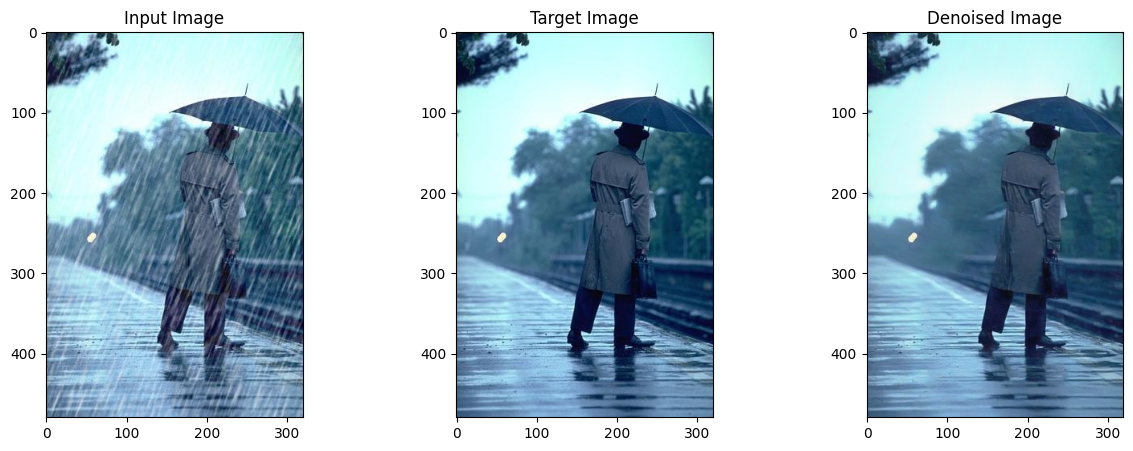

Random Test Image: 915_3.jpg, PSNR: 35.22, SSIM: 0.9414


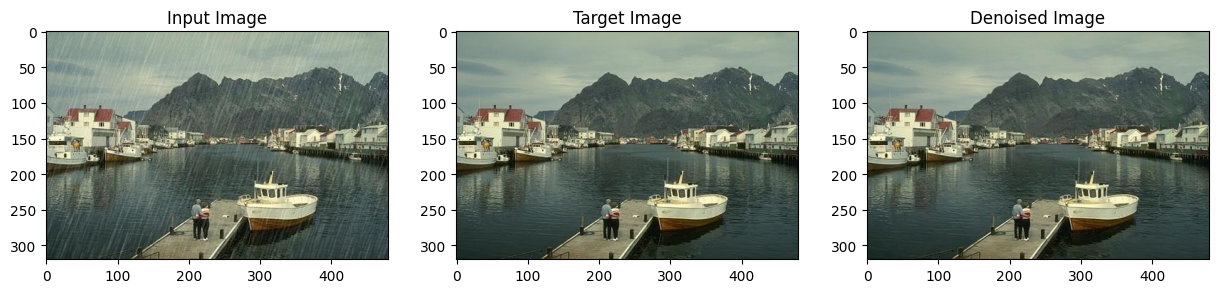

Random Test Image: 930_5.jpg, PSNR: 37.93, SSIM: 0.9731


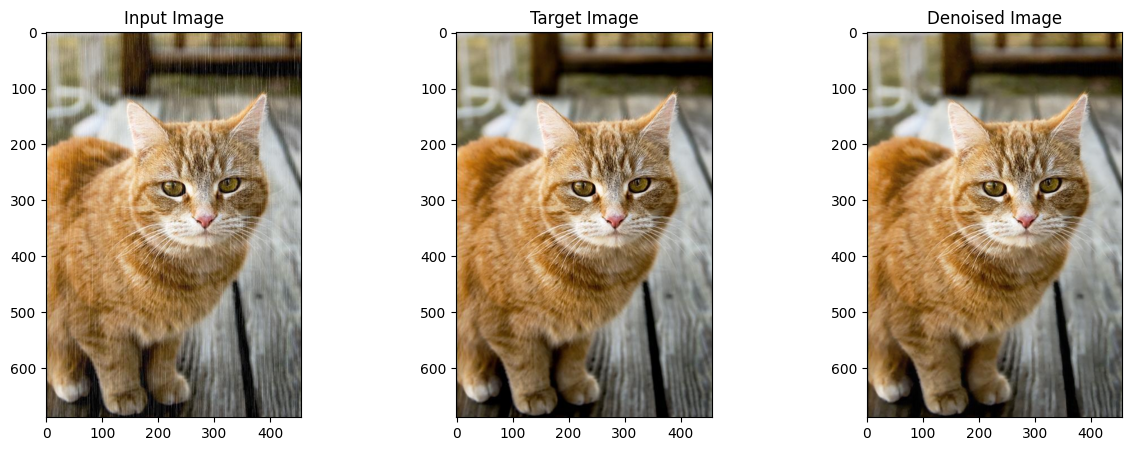

Random Test Image: 917_8.jpg, PSNR: 34.88, SSIM: 0.9507


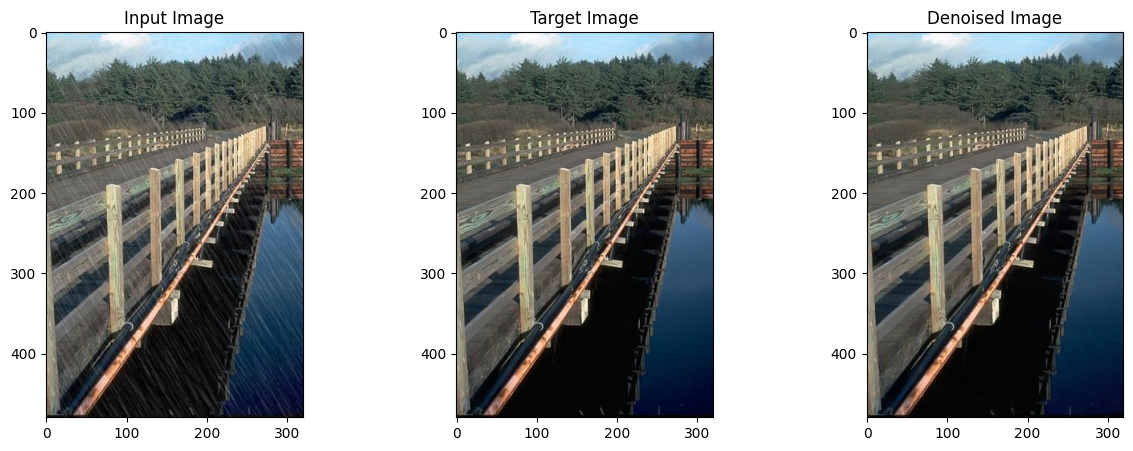

Random Test Image: 961_5.jpg, PSNR: 33.53, SSIM: 0.9366


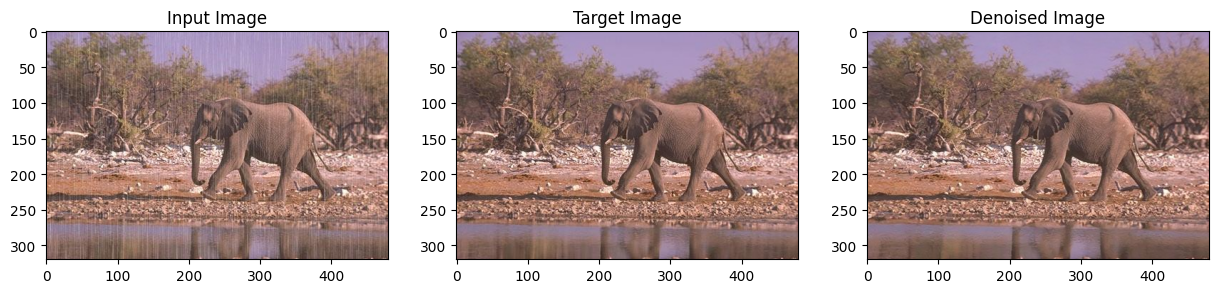

Random Test Image: 816_9.jpg, PSNR: 36.11, SSIM: 0.9457


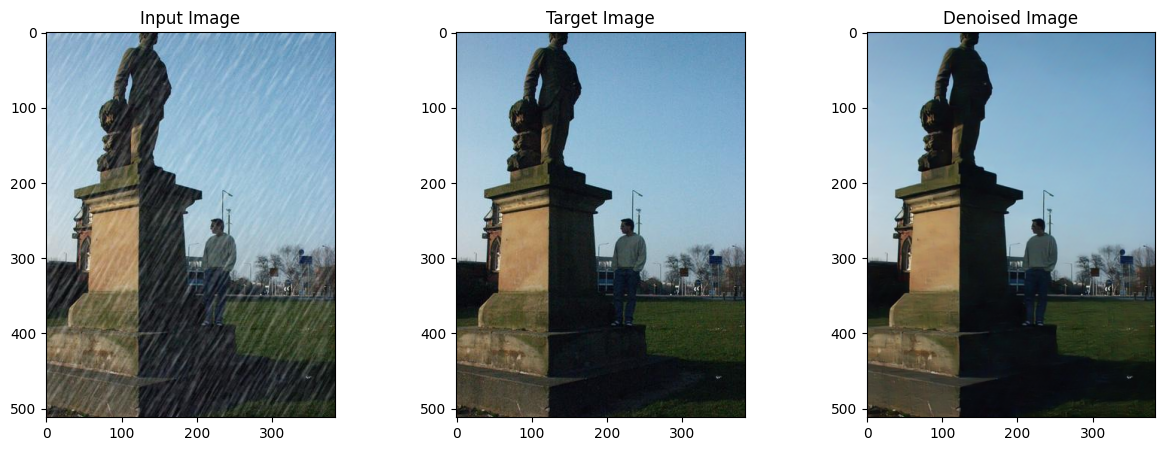

Random Test Image: 868_6.jpg, PSNR: 32.14, SSIM: 0.9715


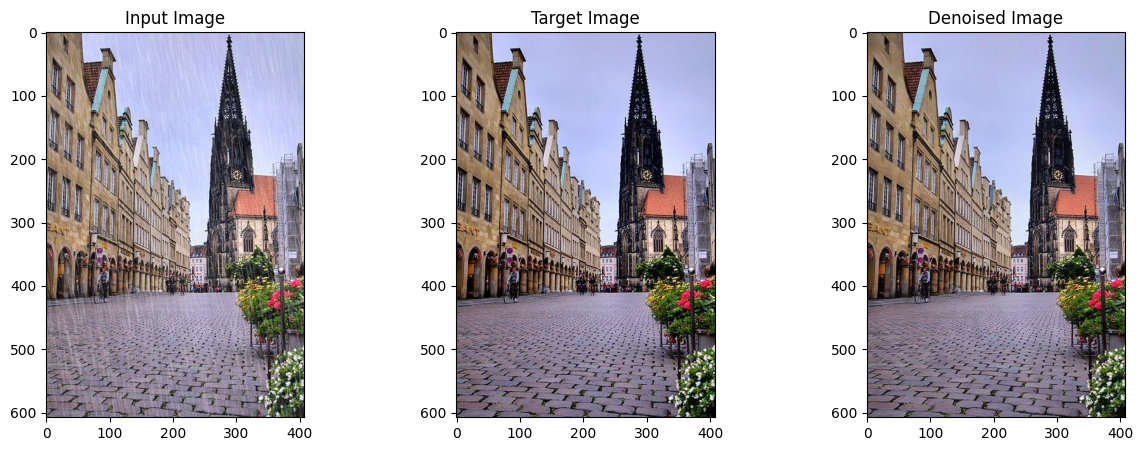

Random Test Image: 814_5.jpg, PSNR: 30.92, SSIM: 0.8982


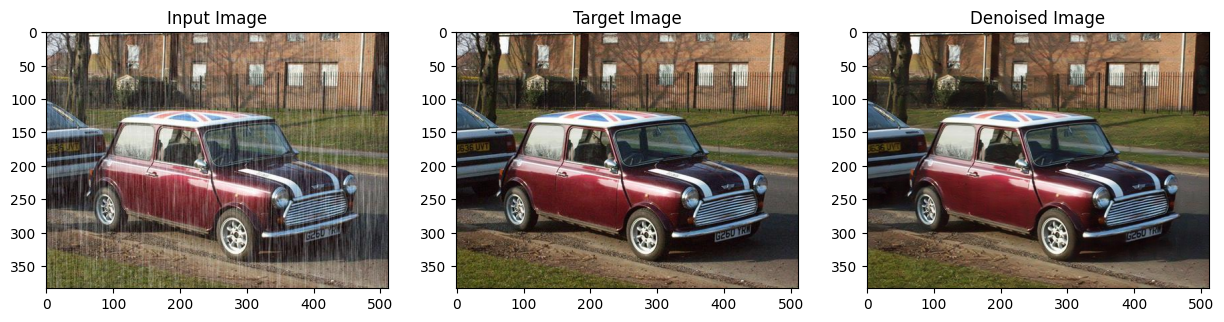

Random Test Image: 994_13.jpg, PSNR: 32.89, SSIM: 0.9491


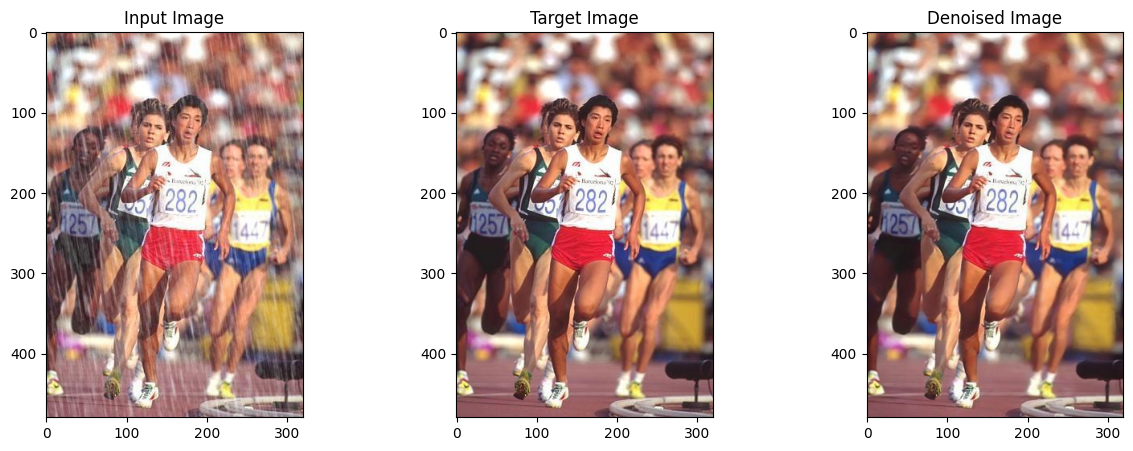

Random Test Image: 920_9.jpg, PSNR: 31.04, SSIM: 0.9288


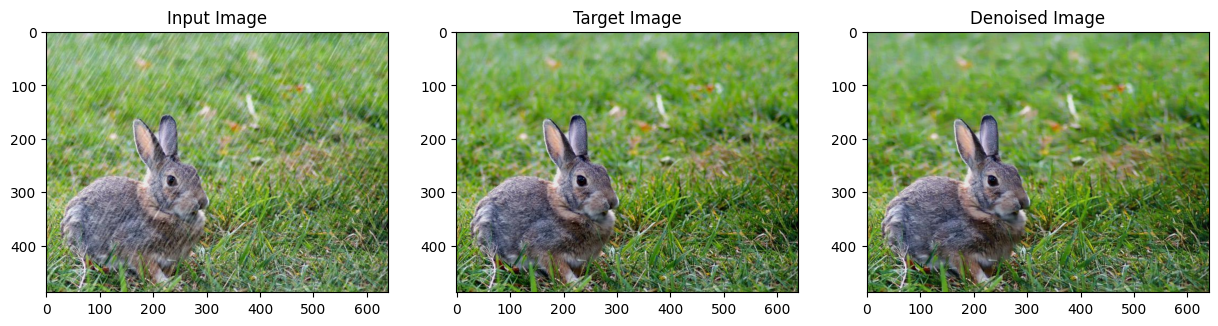

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'results/model_bs4_epoch50.pth'
model = Restormer(args.num_blocks, args.num_heads, args.channels, args.num_refinement, args.expansion_factor).cuda()
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()
for _ in range(10):
    print('='*10)
    process_and_test_random_image(
            model,
            folder_input='/kaggle/input/rain13kdataset/test/test/Test2800/input',
            folder_target='/kaggle/input/rain13kdataset/test/test/Test2800/target'
        )

In [7]:
process_and_test_all_images(
    model,
    folder_input='/kaggle/input/rain13kdataset/test/test/Rain100H/input',
    folder_target='/kaggle/input/rain13kdataset/test/test/Rain100H/target'
)

/tmp/ipykernel_23/317917890.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Processing Images: 100%|██


Average PSNR: 28.50, Average SSIM: 0.8626


In [9]:
process_and_test_all_images(
    model,
    folder_input='/kaggle/input/rain13kdataset/test/test/Rain100L/input',
    folder_target='/kaggle/input/rain13kdataset/test/test/Rain100L/target'
)

Processing Images: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Average PSNR: 34.42, Average SSIM: 0.9587


In [13]:
process_and_test_all_images(
    model,
    folder_input='/kaggle/input/rain13kdataset/test/test/Test100/input',
    folder_target='/kaggle/input/rain13kdataset/test/test/Test100/target'
)

Processing Images: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Average PSNR: 27.92, Average SSIM: 0.8817
